# Урок 4. Сверточные нейронные сети

## Практическое задание

Вариант 1. (простой)

- обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist или cifar10
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
- (опциционально)сравнить с точностью полносвязной сети для этой выборки

Вариант 2. (сложный)
- реализовать нейронную сеть или стек из сверток (Concatenate) на датасете сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
- оценить рост точности при увеличении глубины сети (больше слоев)
- (опциционально) сравнить с точностью полносвязной сети для этой выборки

## 0. Getting into convolution/pooling with 'hand-written' functions

In [1]:
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Flatten, Dense, Dropout, \
                                    Conv2D, GlobalMaxPooling2D, MaxPooling2D, \
                                    AveragePooling2D, GlobalAveragePooling2D 
from tensorflow.keras.utils import plot_model, to_categorical 

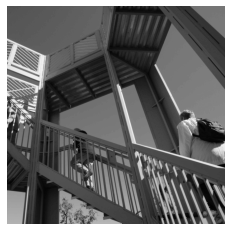

In [2]:
image_1 = misc.ascent()

plt.gray()
plt.axis('off')
plt.imshow(image_1)
plt.show()

### The `function`, which **does convolution** and **returns** `activation map`:

In [3]:
def proceed_convolutional_layer(image, kernel, weight):
    
    shape_x, shape_y = image.shape
    image_t = image.copy()
    
    # iterate through each pixel of the image
    for x in range(1, shape_x - 1):
        for y in range(1, shape_y - 1):

            # init convolutional coefficient
            convolution = 0.0
            
            # multiply area around the pixel by kernel values
            image_slice = image[x-1: x+2, y-1: y+2] 
            convolution = np.sum(image_slice * kernel)

            convolution *= weight

            if convolution < 0:
                convolution = 0
            elif convolution > 255:
                convolution = 255

            image_t[x, y] = convolution
            
    return image_t

In [4]:
def show_image_transformation(image, image_t, 
                              slice_main: tuple = None, 
                              slice_optional: tuple = None):
    
    if slice_main is None:
        x, y = image.shape
        slice_main = (0, x + 1, 0, y + 1)
        
    if slice_optional is None:
        x, y = image_t.shape
        slice_optional = (0, x + 1, 0, y + 1)
        
    plt.figure(figsize=(15, 7))
    plt.gray()
    plt.grid(False)
    plt.subplot(1,2,1)
    plt.imshow(image[slice_main[0]:slice_main[1], slice_main[2]:slice_main[3]])
    plt.subplot(1,2,2)
    plt.imshow(image_t[slice_optional[0]:slice_optional[1], slice_optional[2]:slice_optional[3]])
    plt.axis('off')
    plt.show() 

In [5]:
kernel_1 = [[-1, -2, -1], 
            [0, 0, 0], 
            [1, 2, 1]]

kernel_2 = [[-1, 0, 1], 
            [-2, 0, 2], 
            [-1, 0, 1]]

w  = 1

In [6]:
image_1_conv = proceed_convolutional_layer(image_1, kernel_1, w)

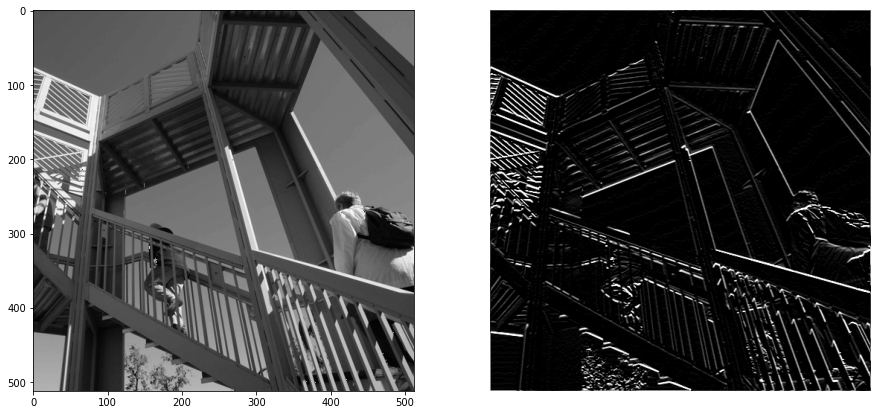

In [7]:
show_image_transformation(image_1, image_1_conv)

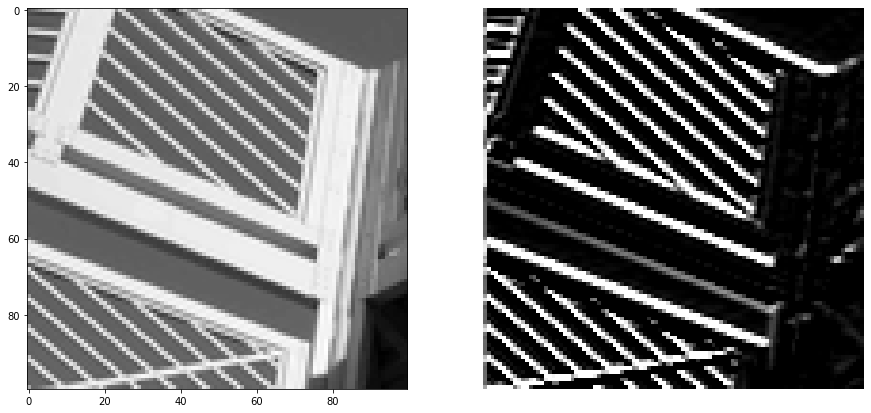

In [8]:
show_image_transformation(image_1, image_1_conv, 
                          slice_main=(100, 200, 0, 100), 
                          slice_optional=(100, 200, 0, 100))

### The `function`, which does pooling and returns `pooled activation map`

In [9]:
def proceed_pooling_layer(image):
    
    shape_x, shape_y = image.shape
    
    new_x, new_y = image.shape
    image_new = np.zeros((new_x // 2, new_y // 2))

    for x in range(0, shape_x, 2):
        for y in range(0, shape_y, 2):
            area = image[x: x+1, y: y+1]
            image_new[x // 2, y // 2] = np.max(area)
    
    return image_new

In [10]:
image_1_conv_pool = proceed_pooling_layer(image_1_conv)

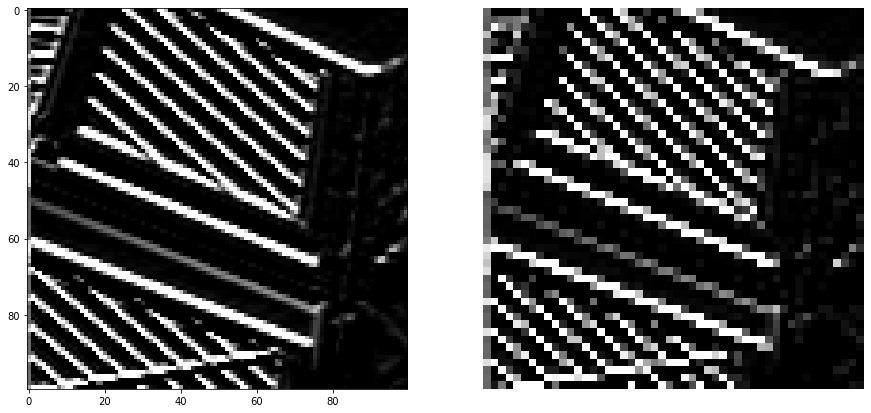

In [11]:
show_image_transformation(image_1_conv, image_1_conv_pool, 
                          slice_main=(100,200,0,100), slice_optional=(50,100,0,50))

## 1. Downloading data

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


### Number of samples

In [3]:
print(f'X_train: {X_train.shape}\nX_test: {X_test.shape}')

X_train: (50000, 32, 32, 3)
X_test: (10000, 32, 32, 3)


### Classes distribution

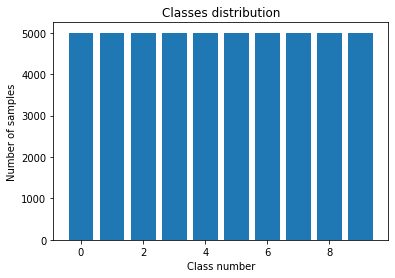

In [4]:
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, height=counts)
plt.title('Classes distribution')
plt.xlabel('Class number')
plt.ylabel('Number of samples')
plt.show()

### Data preview

In [5]:
map_classes = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 
               5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

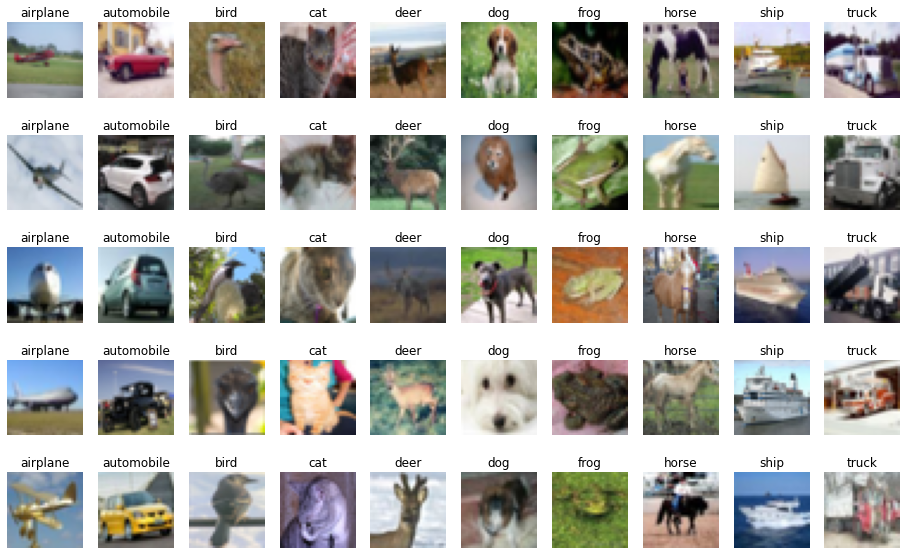

In [6]:
fig, ax = plt.subplots(5, 10, figsize=(16, 10))
np.random.seed(7575)

for row in range(5):
    for col in range(10):
        idx = np.where(y_train == col)
        id = np.random.choice(idx[0])
        ax[row][col].imshow(X_train[id, :, :, :])
        ax[row][col].set_title(map_classes[y_train[id][0]])
        ax[row][col].axis('off')
        
plt.show()

### Data preparation

In [3]:
# one hot encoding
y_train_ohe = to_categorical(y_train, 10)
y_test_ohe = to_categorical(y_test, 10)

# scaling to [0, 1] range
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

## 2. Building CNN

### 2.1. Trying different kernels quantity in convolution layers  

#### 2.1.1. CNN with 1 convolutional layer

In [4]:
batch_size = 128
epochs = 15

results_kernels = {}

for i in range(3, 8):
    tf.random.set_seed(7575)
    kernel_number = 2 ** i

    model = Sequential([
        Conv2D(kernel_number, (3, 3), padding='same', input_shape=X_train.shape[1:]),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(256),
        Activation('relu'),
        Dense(10),
        Activation('softmax'),          
    ])
    

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    history = model.fit(X_train, to_categorical(y_train),
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, to_categorical(y_test)),
                        shuffle=True,
                        verbose=1)
    
    r = model.evaluate(X_test, to_categorical(y_test))
    results_kernels[f'model_{kernel_number}_1_layer'] = (history, r)

Epoch 1/15
391/391 [==============================] - 12s 6ms/step - loss: 1.6474 - accuracy: 0.4155 - val_loss: 1.3974 - val_accuracy: 0.5007
Epoch 2/15
391/391 [==============================] - 2s 6ms/step - loss: 1.3109 - accuracy: 0.5375 - val_loss: 1.2709 - val_accuracy: 0.5522
Epoch 3/15
391/391 [==============================] - 3s 8ms/step - loss: 1.1960 - accuracy: 0.5810 - val_loss: 1.1853 - val_accuracy: 0.5749
Epoch 4/15
391/391 [==============================] - 2s 5ms/step - loss: 1.1107 - accuracy: 0.6101 - val_loss: 1.1426 - val_accuracy: 0.5962
Epoch 5/15
391/391 [==============================] - 2s 5ms/step - loss: 1.0530 - accuracy: 0.6317 - val_loss: 1.1363 - val_accuracy: 0.5991
Epoch 6/15
391/391 [==============================] - 2s 5ms/step - loss: 0.9923 - accuracy: 0.6539 - val_loss: 1.1135 - val_accuracy: 0.6094
Epoch 7/15
391/391 [==============================] - 2s 5ms/step - loss: 0.9407 - accuracy: 0.6704 - val_loss: 1.0880 - val_accuracy: 0.6194
Epoch

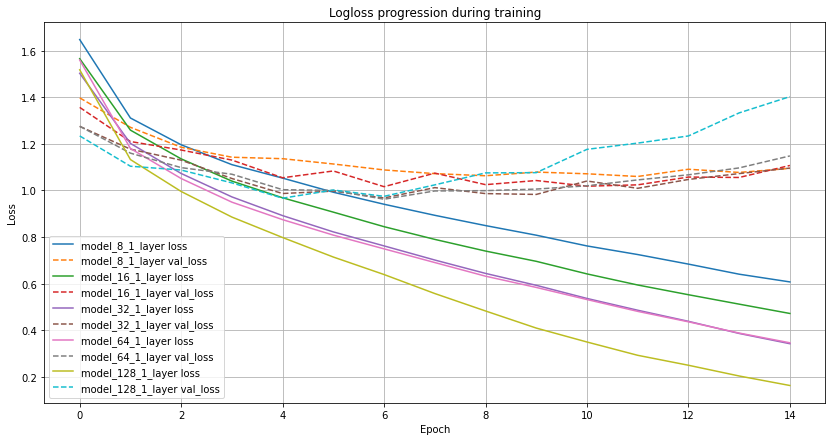

In [5]:
plt.figure(figsize=(14, 7))

for mod in results_kernels:
  plt.plot(range(15), results_kernels[mod][0].history['loss'], '-', label=f'{mod} loss')
  plt.plot(range(15), results_kernels[mod][0].history['val_loss'], '--', label=f'{mod} val_loss')

plt.title('Logloss progression during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(b=True)
plt.legend()
plt.show()

In [6]:
for mod in results_kernels:
  history = results_kernels[mod][0].history
  min_loss_id = np.argmin(history["val_loss"])
  min_acc_id = np.argmax(history['val_accuracy'])
  print(f'{mod}\nbest val_loss -> {history["val_loss"][min_loss_id]:.4f}' 
        f'(best epoch #{min_loss_id})\nfinal val_loss -> {results_kernels[mod][1][0]:.4f}\n'
        f'best accuracy -> {history["val_accuracy"][min_acc_id]:.4f} (best epoch #{min_acc_id})\n')

model_8_1_layer
best val_loss -> 1.0599(best epoch #11)
final val_loss -> 1.0947
best accuracy -> 0.6454 (best epoch #14)

model_16_1_layer
best val_loss -> 1.0162(best epoch #6)
final val_loss -> 1.1072
best accuracy -> 0.6639 (best epoch #11)

model_32_1_layer
best val_loss -> 0.9679(best epoch #6)
final val_loss -> 1.0959
best accuracy -> 0.6787 (best epoch #14)

model_64_1_layer
best val_loss -> 0.9625(best epoch #6)
final val_loss -> 1.1482
best accuracy -> 0.6743 (best epoch #11)

model_128_1_layer
best val_loss -> 0.9668(best epoch #4)
final val_loss -> 1.4025
best accuracy -> 0.6726 (best epoch #6)



#### 2.1.2. CNN with 2 convolutional layers

In [11]:
batch_size = 64
epochs = 15

results = {}

for i in range(3, 9):
    tf.random.set_seed(7575)
    kernel_number = 2 ** i

    model = Sequential()

    model.add(Conv2D(kernel_number, (3, 3), padding='same', input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(kernel_number, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    history = model.fit(X_train, to_categorical(y_train),
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, to_categorical(y_test)),
                        shuffle=True,
                        verbose=1)
    
    r = model.evaluate(X_test, to_categorical(y_test))
    results[f'model_{kernel_number}_2_layers'] = (history, r)

Epoch 1/15
782/782 [==============================] - 4s 5ms/step - loss: 1.7736 - accuracy: 0.3692 - val_loss: 1.5756 - val_accuracy: 0.4427
Epoch 2/15
782/782 [==============================] - 3s 4ms/step - loss: 1.4742 - accuracy: 0.4734 - val_loss: 1.4238 - val_accuracy: 0.4889
Epoch 3/15
782/782 [==============================] - 3s 4ms/step - loss: 1.3695 - accuracy: 0.5131 - val_loss: 1.3567 - val_accuracy: 0.5126
Epoch 4/15
782/782 [==============================] - 3s 4ms/step - loss: 1.2923 - accuracy: 0.5422 - val_loss: 1.3285 - val_accuracy: 0.5279
Epoch 5/15
782/782 [==============================] - 4s 5ms/step - loss: 1.2355 - accuracy: 0.5616 - val_loss: 1.3098 - val_accuracy: 0.5440
Epoch 6/15
782/782 [==============================] - 3s 4ms/step - loss: 1.1800 - accuracy: 0.5840 - val_loss: 1.2341 - val_accuracy: 0.5594
Epoch 7/15
782/782 [==============================] - 4s 5ms/step - loss: 1.1279 - accuracy: 0.6025 - val_loss: 1.2251 - val_accuracy: 0.5722
Epoch 

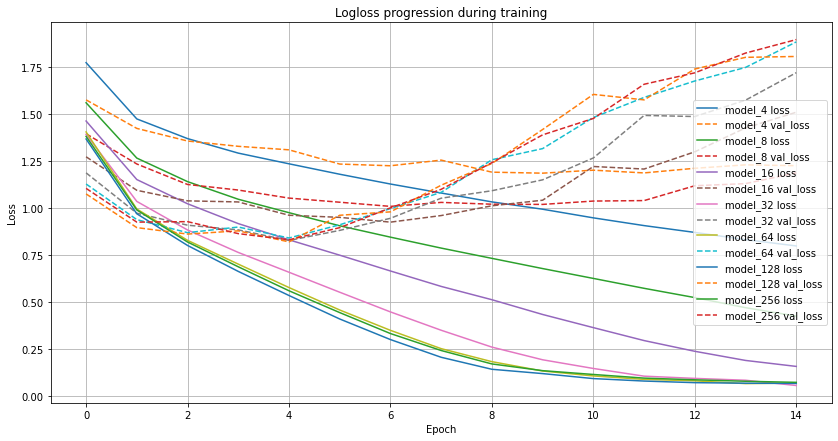

In [12]:
plt.figure(figsize=(14, 7))

for mod in results:
  plt.plot(range(15), results[mod][0].history['loss'], '-', label=f'{mod} loss')
  plt.plot(range(15), results[mod][0].history['val_loss'], '--', label=f'{mod} val_loss')

plt.title('Logloss progression during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(b=True)
plt.legend()
plt.show()

In [14]:
for mod in results:
  history = results[mod][0].history
  min_loss_id = np.argmin(history["val_loss"])
  min_acc_id = np.argmax(history['val_accuracy'])
  print(f'{mod}\nbest val_loss -> {history["val_loss"][min_loss_id]:.4f}' 
        f'(best epoch #{min_loss_id})\nfinal val_loss -> {results[mod][1][0]:.4f}\n'
        f'best accuracy -> {history["val_accuracy"][min_acc_id]:.4f} (best epoch #{min_acc_id})\n')

model_4
best val_loss -> 1.1857(best epoch #9)
final val_loss -> 1.2255
best accuracy -> 0.5900 (best epoch #11)

model_8
best val_loss -> 1.0090(best epoch #6)
final val_loss -> 1.1871
best accuracy -> 0.6670 (best epoch #11)

model_16
best val_loss -> 0.9252(best epoch #6)
final val_loss -> 1.5098
best accuracy -> 0.6846 (best epoch #7)

model_32
best val_loss -> 0.8278(best epoch #4)
final val_loss -> 1.7202
best accuracy -> 0.7167 (best epoch #9)

model_64
best val_loss -> 0.8409(best epoch #4)
final val_loss -> 1.8838
best accuracy -> 0.7209 (best epoch #4)

model_128
best val_loss -> 0.8201(best epoch #4)
final val_loss -> 1.8064
best accuracy -> 0.7333 (best epoch #8)

model_256
best val_loss -> 0.8313(best epoch #4)
final val_loss -> 1.8963
best accuracy -> 0.7262 (best epoch #4)



#### 2.1.3. CNN with 3 convolutional layers

In [11]:
batch_size = 128
epochs = 15

results_kernels_more = {}

for i in range(3, 9):
    tf.random.set_seed(7575)
    kernel_number = 2 ** i

    model = Sequential([
        Conv2D(kernel_number, (3, 3), padding='same', input_shape=X_train.shape[1:]),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(kernel_number, (3, 3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(kernel_number, (3, 3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(256),
        Activation('relu'),
        Dense(10),
        Activation('softmax'),          
    ])
    

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    history = model.fit(X_train, to_categorical(y_train),
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, to_categorical(y_test)),
                        shuffle=True,
                        verbose=1)
    
    r = model.evaluate(X_test, to_categorical(y_test))
    results_kernels_more[f'model_{kernel_number}_3_layers'] = (history, r)

Epoch 1/15
391/391 [==============================] - 3s 7ms/step - loss: 1.8470 - accuracy: 0.3394 - val_loss: 1.6519 - val_accuracy: 0.4155
Epoch 2/15
391/391 [==============================] - 2s 6ms/step - loss: 1.5454 - accuracy: 0.4467 - val_loss: 1.4699 - val_accuracy: 0.4700
Epoch 3/15
391/391 [==============================] - 2s 6ms/step - loss: 1.4335 - accuracy: 0.4897 - val_loss: 1.4044 - val_accuracy: 0.4971
Epoch 4/15
391/391 [==============================] - 2s 6ms/step - loss: 1.3652 - accuracy: 0.5118 - val_loss: 1.3639 - val_accuracy: 0.5090
Epoch 5/15
391/391 [==============================] - 2s 6ms/step - loss: 1.3077 - accuracy: 0.5345 - val_loss: 1.2905 - val_accuracy: 0.5337
Epoch 6/15
391/391 [==============================] - 2s 6ms/step - loss: 1.2608 - accuracy: 0.5529 - val_loss: 1.2594 - val_accuracy: 0.5463
Epoch 7/15
391/391 [==============================] - 2s 6ms/step - loss: 1.2234 - accuracy: 0.5661 - val_loss: 1.2416 - val_accuracy: 0.5587
Epoch 

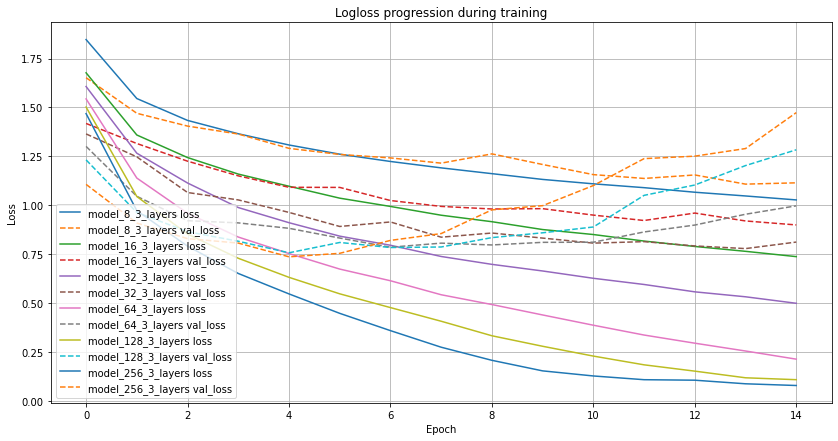

In [12]:
plt.figure(figsize=(14, 7))

for mod in results_kernels_more:
  plt.plot(range(15), results_kernels_more[mod][0].history['loss'], '-', label=f'{mod} loss')
  plt.plot(range(15), results_kernels_more[mod][0].history['val_loss'], '--', label=f'{mod} val_loss')

plt.title('Logloss progression during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(b=True)
plt.legend()
plt.show()

In [13]:
for mod in results_kernels_more:
  history = results_kernels_more[mod][0].history
  min_loss_id = np.argmin(history["val_loss"])
  min_acc_id = np.argmax(history['val_accuracy'])
  print(f'{mod}\nbest val_loss -> {history["val_loss"][min_loss_id]:.4f}' 
        f'(best epoch #{min_loss_id})\nfinal val_loss -> {results_kernels_more[mod][1][0]:.4f}\n'
        f'best accuracy -> {history["val_accuracy"][min_acc_id]:.4f} (best epoch #{min_acc_id})\n')

model_8_3_layers
best val_loss -> 1.1075(best epoch #13)
final val_loss -> 1.1142
best accuracy -> 0.6070 (best epoch #13)

model_16_3_layers
best val_loss -> 0.8988(best epoch #14)
final val_loss -> 0.8988
best accuracy -> 0.6943 (best epoch #14)

model_32_3_layers
best val_loss -> 0.7777(best epoch #13)
final val_loss -> 0.8111
best accuracy -> 0.7351 (best epoch #14)

model_64_3_layers
best val_loss -> 0.7848(best epoch #6)
final val_loss -> 0.9965
best accuracy -> 0.7444 (best epoch #14)

model_128_3_layers
best val_loss -> 0.7563(best epoch #4)
final val_loss -> 1.2832
best accuracy -> 0.7584 (best epoch #10)

model_256_3_layers
best val_loss -> 0.7356(best epoch #4)
final val_loss -> 1.4733
best accuracy -> 0.7612 (best epoch #7)



**RESULTS:**  
- Best results of CNN with 1 conv layer:  
Were provided by the model with 32 kernels.  
`loss -> 0.9157` (on 11-th epoch)  
`accuracy -> 0.6917` (on 14-th epoch)  
  
- Best results of CNN with 2 conv layers:  
Were provided by the model with 128 kernels.  
`loss -> 0.8201` (on 4-th epoch)  
`accuracy -> 0.7333` (on 8-th epoch)
  
- Best results of CNN with 3 conv layers:  
Were provided by the model with 256 kernels.  
`loss -> 0.7356` (on 4-th epoch)  
`accuracy -> 0.7612` (on 7-th epoch)
  
According to the charts and results above:
1. We can see, that the more kernels per convolutional layer we have, the faster model overfits. (On each of three charts the model with 128 kernels per layer has overfitted after the 4-th epoch)
2. Each new convolutional layer was increasing the best loss/accuracy score, BUT with the only condition, that each new layer demands more kernels to perform better.
3. Here is the problem: to simple CNN can't provide us the best result and to complex CNN overfits after a few epochs 

Now let's add Dropout layers to our CNN with 3 convolutional layers.

#### 2.1.3. CNN with Dropout layers

In [17]:
batch_size = 64
epochs = 10

results_dropout = {}

for i in range(2, 8):
    tf.random.set_seed(7575)
    dropout_coef = round(i / 10, 3)
    
    model = Sequential([
            Conv2D(256, (3, 3), padding='same', input_shape=X_train.shape[1:]),
            Activation('relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(dropout_coef),

            Conv2D(256, (3, 3), padding='same'),
            Activation('relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(dropout_coef),

            Conv2D(256, (3, 3), padding='same'),
            Activation('relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(dropout_coef),

            Flatten(),
            Dense(256),
            Activation('relu'),
            Dense(10),
            Activation('softmax'),          
        ])
    
    model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

    history = model.fit(X_train, to_categorical(y_train),
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(X_test, to_categorical(y_test)),
                        shuffle=True,
                        verbose=1)
    
    r = model.evaluate(X_test, to_categorical(y_test))
    results_dropout[f'model_{dropout_coef}_dropout'] = (history, r)

Epoch 1/10
782/782 [==============================] - 15s 19ms/step - loss: 1.5031 - accuracy: 0.4541 - val_loss: 1.1805 - val_accuracy: 0.5702
Epoch 2/10
782/782 [==============================] - 14s 18ms/step - loss: 1.0722 - accuracy: 0.6210 - val_loss: 0.9586 - val_accuracy: 0.6671
Epoch 3/10
782/782 [==============================] - 14s 18ms/step - loss: 0.8960 - accuracy: 0.6853 - val_loss: 0.8271 - val_accuracy: 0.7082
Epoch 4/10
782/782 [==============================] - 14s 18ms/step - loss: 0.7920 - accuracy: 0.7215 - val_loss: 0.7895 - val_accuracy: 0.7234
Epoch 5/10
782/782 [==============================] - 14s 18ms/step - loss: 0.7035 - accuracy: 0.7507 - val_loss: 0.7300 - val_accuracy: 0.7419
Epoch 6/10
782/782 [==============================] - 14s 18ms/step - loss: 0.6335 - accuracy: 0.7757 - val_loss: 0.7119 - val_accuracy: 0.7539
Epoch 7/10
782/782 [==============================] - 14s 18ms/step - loss: 0.5745 - accuracy: 0.7963 - val_loss: 0.7132 - val_accuracy:

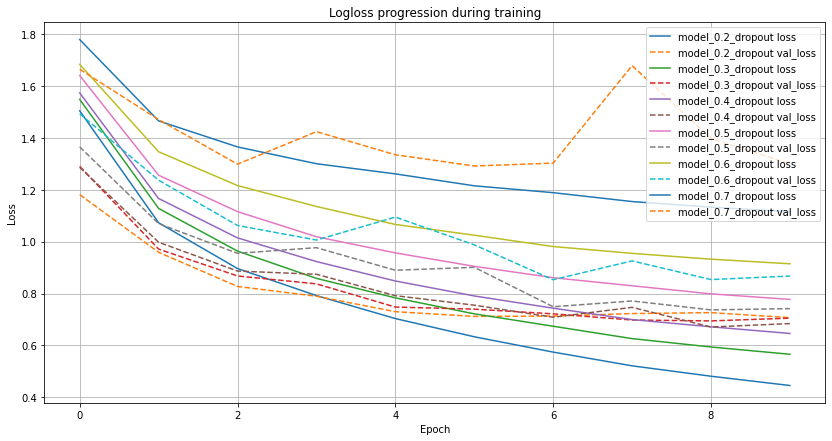

In [18]:
plt.figure(figsize=(14, 7))

for mod in results_dropout:
  plt.plot(range(10), results_dropout[mod][0].history['loss'], '-', label=f'{mod} loss')
  plt.plot(range(10), results_dropout[mod][0].history['val_loss'], '--', label=f'{mod} val_loss')

plt.title('Logloss progression during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(b=True)
plt.legend()
plt.show()

In [19]:
for mod in results_dropout:
  history = results_dropout[mod][0].history
  min_loss_id = np.argmin(history["val_loss"])
  min_acc_id = np.argmax(history['val_accuracy'])
  print(f'{mod}\nbest val_loss -> {history["val_loss"][min_loss_id]:.4f}' 
        f'(best epoch #{min_loss_id})\nfinal val_loss -> {results_dropout[mod][1][0]:.4f}\n'
        f'best accuracy -> {history["val_accuracy"][min_acc_id]:.4f} (best epoch #{min_acc_id})\n')

model_0.2_dropout
best val_loss -> 0.7071(best epoch #9)
final val_loss -> 0.7071
best accuracy -> 0.7642 (best epoch #9)

model_0.3_dropout
best val_loss -> 0.6945(best epoch #8)
final val_loss -> 0.7052
best accuracy -> 0.7624 (best epoch #8)

model_0.4_dropout
best val_loss -> 0.6710(best epoch #8)
final val_loss -> 0.6842
best accuracy -> 0.7680 (best epoch #8)

model_0.5_dropout
best val_loss -> 0.7369(best epoch #8)
final val_loss -> 0.7418
best accuracy -> 0.7441 (best epoch #8)

model_0.6_dropout
best val_loss -> 0.8530(best epoch #6)
final val_loss -> 0.8672
best accuracy -> 0.7036 (best epoch #8)

model_0.7_dropout
best val_loss -> 1.2909(best epoch #5)
final val_loss -> 1.2995
best accuracy -> 0.5516 (best epoch #5)



Now we see, that every model didn't overfit after 4-th epoch, as it was earlier.  
  
The best result was reached by the model with Dropout layers with coefficient 0.4:
- `loss -> 0.6710` (best epoch #8)  
`accuracy -> 0.7680` (best epoch #8)
  
Also, this result is better, than the previous, which was received with the same model, but without Dropout layers.  
  
Best results without Dropout:
- `loss -> 0.7356` (on 4-th epoch)  
`accuracy -> 0.7612` (on 7-th epoch)  
  
## Conclusions:
1. CNNs are hard to calculate. After 1 day of experiments, I suddenly ran out of GPU limits of Google Colab and further calculations seems not possible on my laptop :)
2. When you make a CNN more complex (add kernels/layers) you have to add Dropout or Batch Normalization layers, because complex nets not only can give you the best results, but also overfits fast.
